# Modelagem Preditiva de Séries Temporais - Em Python

# <font color='blue'>Deep Learning - Recurrent Neural Networks (RNN)</font>

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

Redes Neurais Recorrentes ou RNNs são um tipo especial de rede neural projetada para problemas sequenciais. Considerando uma rede padrão Multilayer Perceptron, uma rede neural recorrente pode ser pensada como a adição de loops à arquitetura. Por exemplo, em uma dada camada, cada neurônio pode passar seu sinal para frente (feed-forward) e também para o lado. 

Uma Rede Neural Recorrente é basicamente uma rede neural que pode ser usada quando seus dados são tratados como uma sequência, onde a ordem particular dos pontos de dados é importante e esta sequência pode ser de comprimento arbitrário.

O exemplo mais claro é talvez uma série temporal de números, onde a tarefa é prever o próximo valor de acordo com valores anteriores. A entrada para a RNN em cada passo de tempo é o valor atual, bem como um vetor de estado que representa o que a rede "viu" no tempo - etapas anteriores. Este estado-vetor é a memória codificada da RNN, inicialmente definida como zero.

![RNN](images/rnn01.png "RNN")

## Sequências

Mas você pode estar se perguntando: o que torna a Recurrent Neural Network tão especial? Uma limitação flagrante das Redes Neurais clássicas (e também das Redes Convolucionais) é que seu modelo é muito restrito: eles aceitam um vetor de tamanho fixo como entrada (por exemplo, uma imagem) e produzem um vetor de tamanho fixo como saída (por exemplo, probabilidades de diferentes classes ). Não só isso: esses modelos executam esse mapeamento usando uma quantidade fixa de etapas computacionais (por exemplo, o número de camadas no modelo). A principal razão pela qual as redes recorrentes são mais eficientes é que elas nos permitem operar sobre sequências de vetores: sequências na entrada, na saída ou no caso mais geral em ambos. Alguns exemplos podem tornar isso mais concreto:

![RNN](images/diags.jpeg "RNN")

Existem alguns tipos de problemas que são melhor enquadrados envolvendo uma sequência como entrada ou
uma saída. Por exemplo, considere um problema de séries temporais univariadas, como o preço de ações ns bolsas de valores ao longo do tempo. Este conjunto de dados pode ser enquadrado como um problema de previsão para uma Rede Multilayer Perceptron clássica, definindo um tamanho de janela (por exemplo, 5) e treinando a rede para aprender a fazer previsões de curto prazo a partir da janela de entrada de tamanho x.

Isso funcionaria, mas é muito limitado. A janela de entradas adiciona memória ao problema, mas é limitado a apenas um número x de pontos e deve ser escolhido com um conhecimento adequado do problema. Um valor de janela inadequado não capturaria as tendências mais amplas em minutos, horas e dias que podem ser relevantes para fazer uma previsão. De uma previsão para a próxima, a rede só conhece as entradas especificadas que são fornecidas. 

Consideremos a seguinte taxonomia de problemas de sequência que requerem um mapeamento de uma entrada para um resultado:

* One-to-Many: saída de sequência, usada para gerar legendas para imagens em vídeos.
* Many-to-One: entrada de sequência, para classificação de sentimento.
* Many-to-Many: sequência de entrada e saída, para tradução automática.
* Synchronized Many-to-Many: sequências sincronizadas de entrada e saída, para classificar vídeo.

## Como Treinar Redes Neurais Recorrentes (BPTT ou BackPropagation Through Time)


A RNN consiste em um grupo de unidades de entrada rotuladas (representada pela letra u neste diagrama) e unidades de saída rotuladas (representadas pela letra y neste diagrama). Existem também as unidades ocultas que fazem a maior parte do trabalho interessante. Você pode notar que a ilustração mostra um fluxo unidirecional de informações das unidades de entrada para as unidades ocultas, bem como outro fluxo unidirecional de informações das unidades ocultas para as unidades de saída. Entretanto, existem conexões cíclicas nas camadas ocultas, que é exatamente a arquitetura de RNN’s. Em alguns casos, as RNNs quebram as restrições com conexões que conduzem das unidades de saída de volta para as unidades ocultas. Estes são chamados "backprojections", e fazem a análise de RNNs muito mais complexa. As mesmas técnicas que discutimos aqui também se aplicam a RNNs com backprojections. Existem muitas dificuldades técnicas envolvidas no treinamento redes neurais recorrentes, e ainda é uma área muito ativa em pesquisa. 

![RNN](images/rnn02.png "RNN")

Em um modelo Multiplayer Perceptron clássico, o erro da rede é retro-propagado e usado para atualizar os pesos da rede. Entretanto, essa mesma estratégia em uma rede neural recorrente provoca 2 possíveis consequências com o gradiente: tende ao infinito, quando o valor é muito grande, ou a degradação, quando o valor é muito pequeno, devido as conexões recorrentes. Ambos os casos são problemas, mas foram resolvidos (ou amenizados) com uma modificação na técnica de Backpropagation chamada BPTT ou BackPropagation Through Time.

Uma vez definida a arquitetura da RNN, é possível iniciar o treinamento por meio da minimização de uma função de custo J. Nesse caso, uma variante do algoritmo backpropagation é utilizada, a denominada retropropagação através do tempo (Backpropagation Through Time, BPTT). O BPTT pode ser entendido se considerarmos que uma RNN corresponde a uma rede alimentada adiante (ou feed forward) com uma camada para cada passo de tempo e na qual a matriz de pesos de cada camada é a mesma, se considerarmos o desdobramento da rede através do tempo. (Aliás, é dessa perspectiva que se originou o nome do algoritmo BPTT.) Dessa forma, após o fornecimento da sequência de entrada, os gradientes são calculados (da mesma maneira que nas redes feed-forward) e posteriormente alterados para manter a restrição de igualdade da matriz de pesos em cada camada oculta. 

![BPTT](images/BPTT.png "BPTT")

## Como Obter Gradientes Estáveis Durante o Treinamento da RNN

Quando Backpropagation é usado em redes neurais profundas e redes neurais recorrentes, os gradientes que são calculados para atualizar os pesos podem ser tornar instáveis. Os gradientes podem assumir valores muito grandes, levando ao que chamados de "explosão dos gradientes" ou valores muitos pequenos, levando ao que chamamos de "degradação dos gradientes" (Vanishing Gradient). Ambos os casos são ruins e tornam o treinamento instável e a rede com previsões não confiáveis.

Este problema é aliviado em redes neurais profundas através do uso da função de ativação 'tanh' e com o uso de técnicas mais exóticas e menos populares como o uso de Pré-treinamento não supervisionado de camadas. Nas arquiteturas redes neurais recorrentes, esse problema foi amenizado usando um novo tipo de arquitetura chamada Long Short-Term Memory Networks (LSTMs) que permite a formação de redes recorrentes profundas.

## LSTMs

A principal característica das RNNs para a classificação de sequências é a habilidade de usar informação contextual para realizar o mapeamento entre as entradas e as saídas. O problema é que a influência de uma entrada na camada intermediária e, consequentemente, na camada de saída, ou cresce exponencialmente ou é diluída enquanto circula pelas conexões recorrentes da rede. Conhecidos como problemas de explosão do gradiente e dissipação do gradiente (vanishing gradient problem), eles tornam difícil para RNNs aprender tarefas que contenham mais que dez atrasos no tempo (timesteps) entre a apresentação de entradas relevantes e eventos esperados. Neste diagrama é possível observar a dissipação do gradiente com o tempo. À medida que novas entradas são apresentadas à rede, a ativação da camada intermediária é sobrescrita e a rede ”esquece‟ as primeiras entradas. Dentre várias soluções propostas para reduzir os impactos da dissipação do gradiente em RNNs, a solução mais efetiva é a arquitetura Long Short-Term Memory (LSTM).

![RNN](images/rnn03.png "RNN")

As Long Short-Term Memory Networks (LSTMs) são redes neurais recorrentes treinadas usando a retro-propagação ao longo do tempo (BPTT) e ajudam a superar o problema da degradação do gradiente. Assim sendo, essa arquitetura pode ser usada para criar redes recorrentes grandes (empilhadas), que, por sua vez, podem ser usadas para endereçar problemas de sequência e obter resultados de ponta. 

Ao invés de neurônios, as redes LSTM possuem blocos de memória conectados em camadas. Um bloco tem componentes que o tornam mais inteligente do que um neurônio clássico e uma memória para sequências recentes. Um bloco contém "portões" que gerenciam o estado e a saída do bloco. Uma unidade opera em uma sequência de entrada e cada portão dentro de uma unidade usa a função de ativação sigmoid para controlar se eles são acionados ou não, fazendo a mudança de estado e adição de informação. Existem três tipos de portões dentro de uma unidade de memória:

* Forget Gate: condicionalmente decide que informação deve ser descartada da unidade.
* Input Gate: condicionalmente decide que valores do input que devem ter o estado de memória atualizado.
* Output Gate: condicionalmente decide o que gerar como output com base no input e na memória da unidade.

![LSTM](images/lstm.jpg "LSTM")

A arquitetura LSTM consiste de um conjunto de sub-redes conectadas recorrentemente. Essas sub-redes, chamadas de blocos de memória, podem ser consideradas uma metáfora de chips de memória. Cada bloco possui uma ou mais células de memória autoconectadas e três unidades de multiplicação que definem a operação que deve ser realizada, as portas de entrada, saída e de esquecimento. Voltando à analogia com chips de memória, essas operações podem ser interpretadas como as operações de escrita, leitura e de limpeza (reset) dos circuitos.

A única diferença estrutural de uma rede LSTM para uma RNN é que os elementos da camada intermediária deixam de ser neurônios com funções de ativação não lineares e passam a ser blocos de memória. O chaveamento das portas permite preservar a informação do bloco por muito tempo, evitando o problema da degradação do gradiente. Enquanto a porta de entrada estiver fechada, a ativação da célula de informação não será alterada, podendo ser acessada em um outro momento ativando a porta de saída. A informação é mantida na célula através de uma conexão recorrente de peso 1.

![RNN](images/rnn04.png "RNN")

A Rede LSTM preserva o gradiente da informação como ilustrado nesse diagrama. A sensibilidade do bloco de memória pode ser controlada pela porta de saída sem afetar a célula de informação do bloco. Por fim, a entrada só afeta a informação quando a porta de entrada está aberta.

Cada unidade é como uma mini-máquina de estado onde os portões das unidades têm pesos que são aprendidos durante o procedimento de treinamento. Isso permite uma aprendizagem sofisticada e memória em cada uma das camadas de LSTMs, e não é difícil imaginar abstrações de ordem superior quando utilizadas várias camadas.

## Prevendo Séries Temporais com Multilayer Perceptron


Previsão de Capacidade do Mainframe - Consumo dos Jobs do Broker

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o Consumo dos Jobs do Broker. 

In [1]:
# Importa TF2
import tensorflow as tf
tf.__version__

'2.10.0'

In [2]:
# Imports
import math
import pandas as pd
import numpy
import matplotlib.pyplot as plt

# Importa Keras TF2
from tensorflow import keras   
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import MinMaxScaler

from pandas.tseries.offsets import DateOffset
from time import time
from datetime import datetime

# Imports para visualização de dados
import matplotlib as m

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [3]:
# Random seed 
numpy.random.seed(7)

In [4]:
# Carrega os dataframe
dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)
dataframe

,Data,Broker,Service_name,Service_class,Programa,Quantidade
0,2021-11-27,ETB160,DETRAN,SDGX,NSDGX047,6
1,2021-11-27,ETB160,DETRAN,SDGX,NSDAKG12,1
2,2021-11-27,ETB160,DETRAN,SDGX,NSDAKQ08,1
3,2021-11-27,ETB160,DETRAN,SDGX,NSDAKQ07,1
4,2021-11-27,ETB160,DETRAN,SDGX,NSDGX414,1
...,...,...,...,...,...,...
71289,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX500,217
71290,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX495,9
71291,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX469,121
71292,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX467,12


In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71294 entries, 0 to 71293
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Data           71294 non-null  datetime64[ns]
 1   Broker         71294 non-null  object        
 2   Service_name   71294 non-null  object        
 3   Service_class  71294 non-null  object        
 4   Programa       71294 non-null  object        
 5   Quantidade     71294 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 3.3+ MB


In [6]:
# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

dataset = dataframe.copy()

filtro1 = dataset['Broker']=='ETB170'
filtro2 = dataset['Service_name']=='PORTALDETRAN'
filtro3 = dataset['Programa']=='NSDGX500'
dataset = dataset[filtro1 & filtro2 & filtro3]

dataset = dataset.rename_axis('index').reset_index()
dataset.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)
dataset

,Data,Quantidade
0,2021-11-27,96
1,2021-11-26,82
2,2021-11-25,50
3,2021-11-24,50
4,2021-11-23,100
...,...,...
572,2022-10-21,78
573,2022-10-22,65
574,2022-10-24,79
575,2022-10-25,176


In [7]:
dataset

,Data,Quantidade
0,2021-11-27,96
1,2021-11-26,82
2,2021-11-25,50
3,2021-11-24,50
4,2021-11-23,100
...,...,...
572,2022-10-21,78
573,2022-10-22,65
574,2022-10-24,79
575,2022-10-25,176


In [8]:
# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

dataset.drop_duplicates(subset='Data', inplace=True)
dataset = dataset.set_index('Data')
dataset = dataset.resample('D').interpolate()
dataset

,Quantidade
Data,
2021-10-26,162.0
2021-10-27,66.0
2021-10-28,58.0
2021-10-29,44.0
2021-10-30,83.0
...,...
2022-10-21,207.0
2022-10-22,22.0
2022-10-23,50.5


In [9]:
dataset = dataset.values
dataset = dataset.astype('float32')

In [10]:
# Dados
dataset

array([[162.      ],
       [ 66.      ],
       [ 58.      ],
       [ 44.      ],
       [ 83.      ],
       [ 84.5     ],
       [ 86.      ],
       [ 87.      ],
       [ 88.      ],
       [ 63.      ],
       [212.      ],
       [ 64.      ],
       [ 90.5     ],
       [117.      ],
       [ 50.      ],
       [115.      ],
       [ 54.      ],
       [ 92.      ],
       [124.      ],
       [103.333336],
       [ 82.666664],
       [ 62.      ],
       [106.      ],
       [ 33.      ],
       [120.      ],
       [107.      ],
       [145.5     ],
       [184.      ],
       [100.      ],
       [ 50.      ],
       [ 50.      ],
       [ 82.      ],
       [ 96.      ],
       [ 83.      ],
       [ 70.      ],
       [ 98.      ],
       [  4.      ],
       [111.      ],
       [194.      ],
       [  3.      ],
       [ 48.5     ],
       [ 94.      ],
       [ 95.      ],
       [135.      ],
       [ 14.      ],
       [  4.      ],
       [215.      ],
       [109. 

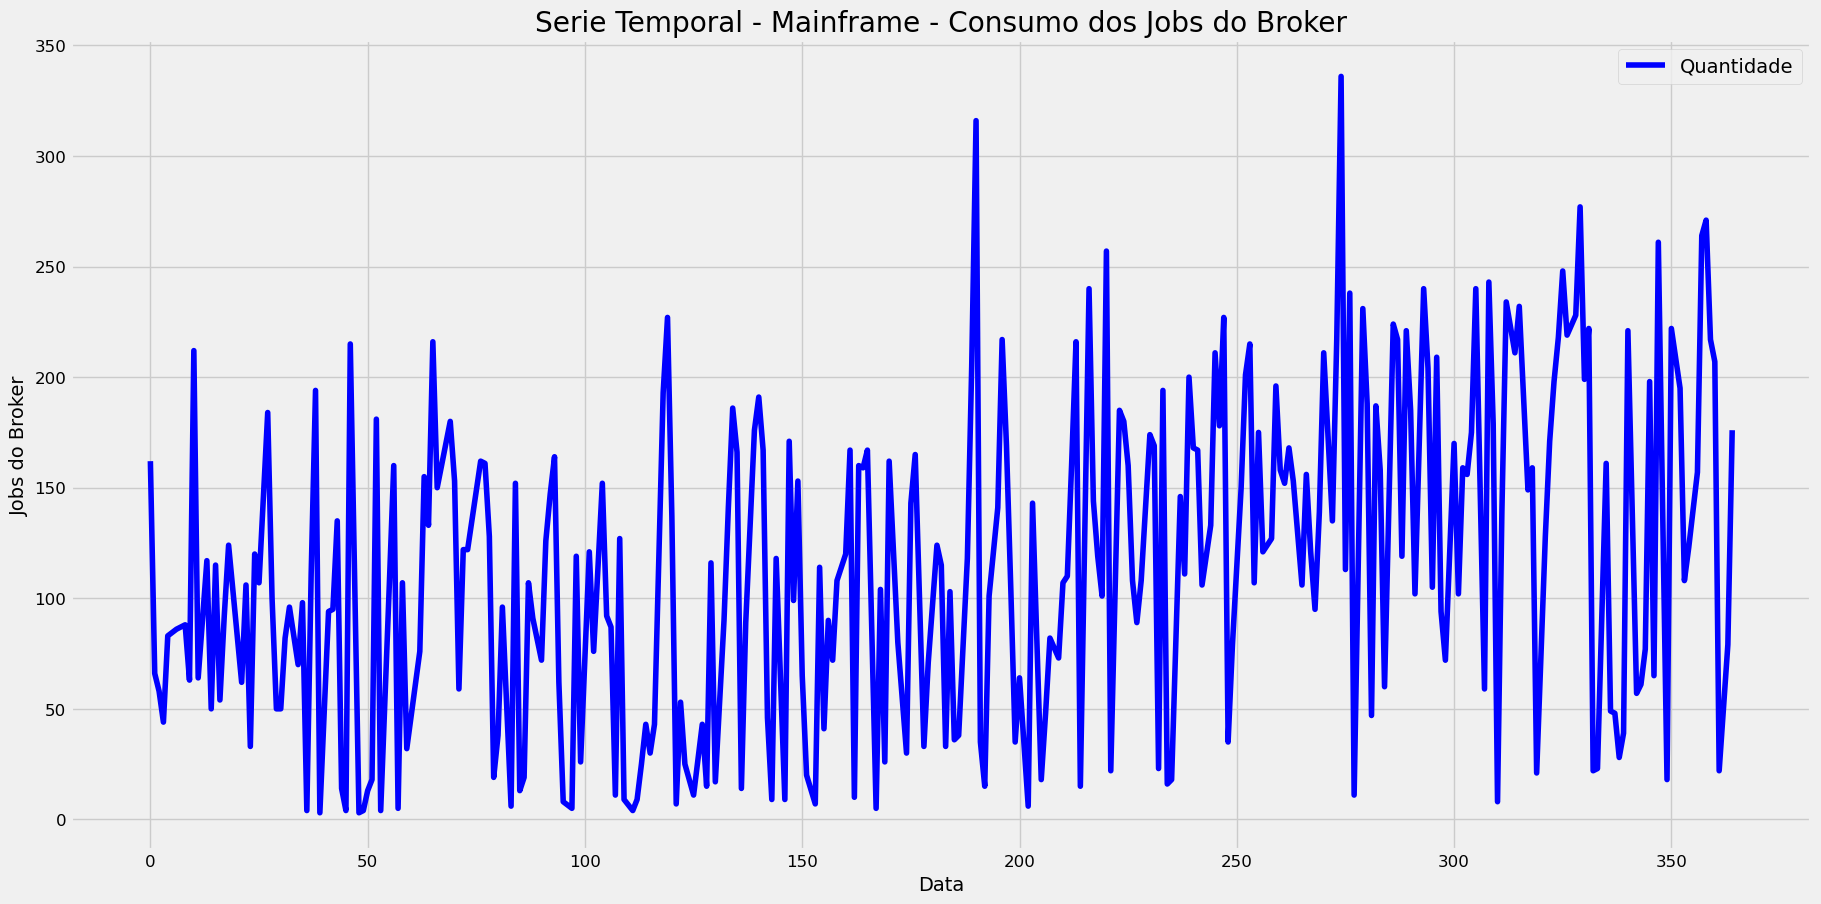

In [11]:
# Plot
plt.title("Serie Temporal - Mainframe - Consumo dos Jobs do Broker")
plt.plot(dataset, label = "Quantidade", color = 'blue')
plt.xlabel("Data")
plt.ylabel("Jobs do Broker")
plt.legend(loc = "best")

In [12]:
# Split em treino e teste
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

273 92


In [13]:
# Agora podemos definir uma função para criar um novo conjunto de dados como descrito acima. A função
# recebe 2 argumentos: o conjunto de dados, que é um array NumPy que queremos converter em um dataset e
# look back que é o número de etapas de tempo anteriores para usar como variáveis de entrada para prever
# O próximo período de tempo, neste caso, definido como 1. Esse padrão criará um conjunto de dados onde X é
# o número de passageiros em um determinado momento (t) e Y é o número de passageiros no próximo
# momento (t + 1). 
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [14]:
# Reshape em X = t e Y = t + 1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Imprimindo dataset de treino
#print(trainX[0:2], trainY[0:2])

# Imprimindo dataset original
#print("\n", dataset[0:3])

In [15]:
# Cria o modelo MLP - RNA - com 1 input, 1 camada oculta com 8 neurônios e uma camada de saída

# Treinamento
start = time()
current_time = datetime.now().strftime("%H:%M:%S")
print("Hora de Início =", current_time)

model = Sequential()

# Camada oculta
model.add(Dense(8, input_dim = look_back, activation = 'relu'))

# Camada de saída
model.add(Dense(1))

# Compilação
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# Fit do modelo
model.fit(trainX, trainY, epochs = 200, batch_size = 2, verbose = 2)

current_time = datetime.now().strftime("%H:%M:%S")
print("\nHora de Término =", current_time)    
print ('Tempo gasto: %s segundos' % str(time() - start))

Hora de Início = 20:42:57
Epoch 1/200
136/136 - 2s - loss: 18714.9844 - 2s/epoch - 12ms/step
Epoch 2/200
136/136 - 1s - loss: 16185.1348 - 542ms/epoch - 4ms/step
Epoch 3/200
136/136 - 1s - loss: 14928.9502 - 557ms/epoch - 4ms/step
Epoch 4/200
136/136 - 1s - loss: 14244.8408 - 536ms/epoch - 4ms/step
Epoch 5/200
136/136 - 1s - loss: 13859.5371 - 543ms/epoch - 4ms/step
Epoch 6/200
136/136 - 1s - loss: 13621.8418 - 546ms/epoch - 4ms/step
Epoch 7/200
136/136 - 1s - loss: 13534.7363 - 550ms/epoch - 4ms/step
Epoch 8/200
136/136 - 1s - loss: 13511.3574 - 535ms/epoch - 4ms/step
Epoch 9/200
136/136 - 1s - loss: 13487.8740 - 542ms/epoch - 4ms/step
Epoch 10/200
136/136 - 1s - loss: 13464.2510 - 536ms/epoch - 4ms/step
Epoch 11/200
136/136 - 1s - loss: 13440.5068 - 541ms/epoch - 4ms/step
Epoch 12/200
136/136 - 1s - loss: 13416.7080 - 536ms/epoch - 4ms/step
Epoch 13/200
136/136 - 1s - loss: 13392.8633 - 548ms/epoch - 4ms/step
Epoch 14/200
136/136 - 1s - loss: 13369.1299 - 589ms/epoch - 4ms/step
Epoch

Epoch 118/200
136/136 - 1s - loss: 11062.2080 - 535ms/epoch - 4ms/step
Epoch 119/200
136/136 - 1s - loss: 11042.0352 - 521ms/epoch - 4ms/step
Epoch 120/200
136/136 - 1s - loss: 11021.7725 - 542ms/epoch - 4ms/step
Epoch 121/200
136/136 - 1s - loss: 11001.5381 - 539ms/epoch - 4ms/step
Epoch 122/200
136/136 - 1s - loss: 10981.2139 - 530ms/epoch - 4ms/step
Epoch 123/200
136/136 - 1s - loss: 10961.0059 - 533ms/epoch - 4ms/step
Epoch 124/200
136/136 - 1s - loss: 10940.7412 - 512ms/epoch - 4ms/step
Epoch 125/200
136/136 - 1s - loss: 10920.5918 - 536ms/epoch - 4ms/step
Epoch 126/200
136/136 - 1s - loss: 10900.4434 - 546ms/epoch - 4ms/step
Epoch 127/200
136/136 - 1s - loss: 10880.3711 - 518ms/epoch - 4ms/step
Epoch 128/200
136/136 - 1s - loss: 10860.3154 - 538ms/epoch - 4ms/step
Epoch 129/200
136/136 - 1s - loss: 10840.3672 - 531ms/epoch - 4ms/step
Epoch 130/200
136/136 - 1s - loss: 10820.3320 - 522ms/epoch - 4ms/step
Epoch 131/200
136/136 - 1s - loss: 10800.3213 - 535ms/epoch - 4ms/step
Epoch 

In [16]:
# Estima a performance do modelo
# Tomando a raiz quadrada das estimativas de desempenho, podemos ver que o modelo tem um
# erro médio no conjunto de dados de treinamento e no conjunto de dados de teste.

trainScore = model.evaluate(trainX, trainY, verbose = 0)
print('Score em Treino: %.4f MSE (%.4f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose = 0)
print('Score em Teste: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

Score em Treino: 3883.2266 MSE (62.3155 RMSE)
Score em Teste: 7070.1509 MSE (84.0842 RMSE)


In [17]:
# Gera previsões
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

3/3 [==============================] - 0s 3ms/step


In [18]:
# Ajusta os dados de treino para o Plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [19]:
# Ajusta os dados de teste para o Plot
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

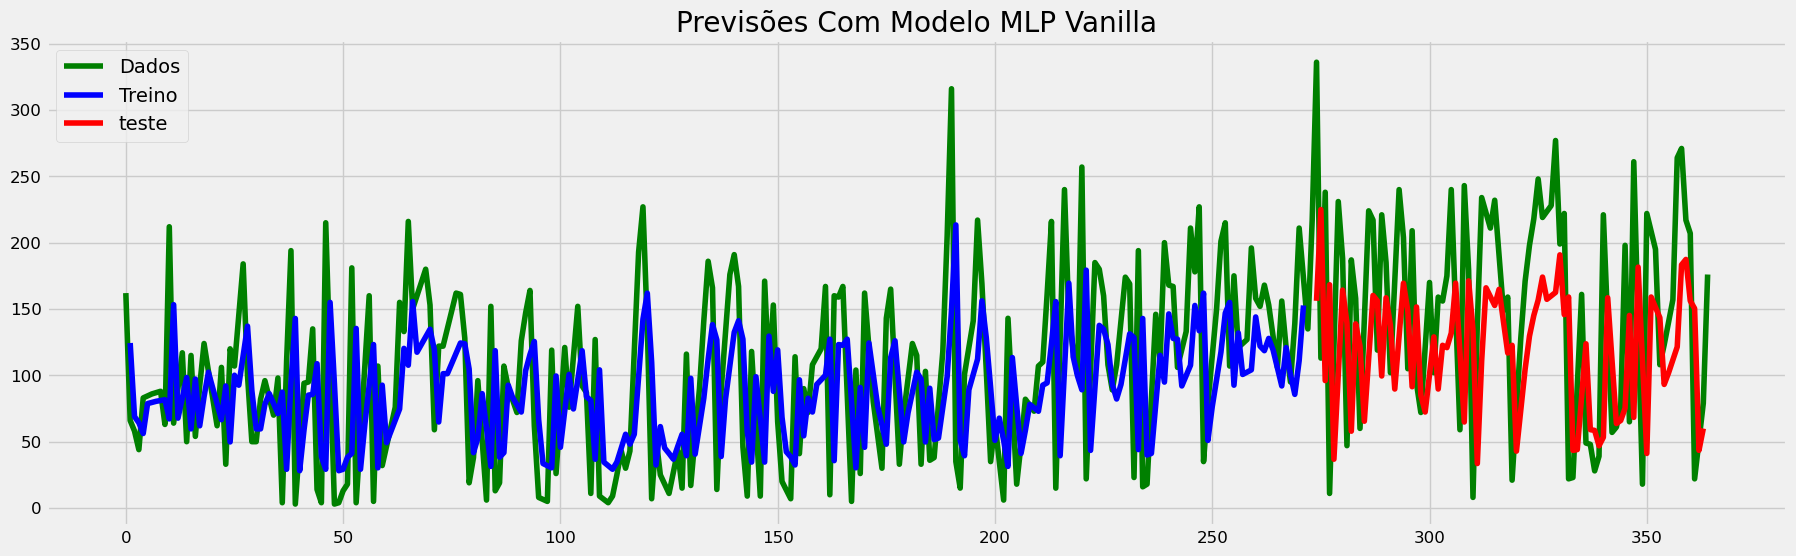

In [20]:
# Plot
plt.figure(figsize = (20, 6))
plt.title('Previsões Com Modelo MLP Vanilla')
plt.plot(dataset, label = 'Dados', color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(testPredictPlot, label = 'teste', color = 'Red')
plt.legend(loc = 'upper left')
plt.show()

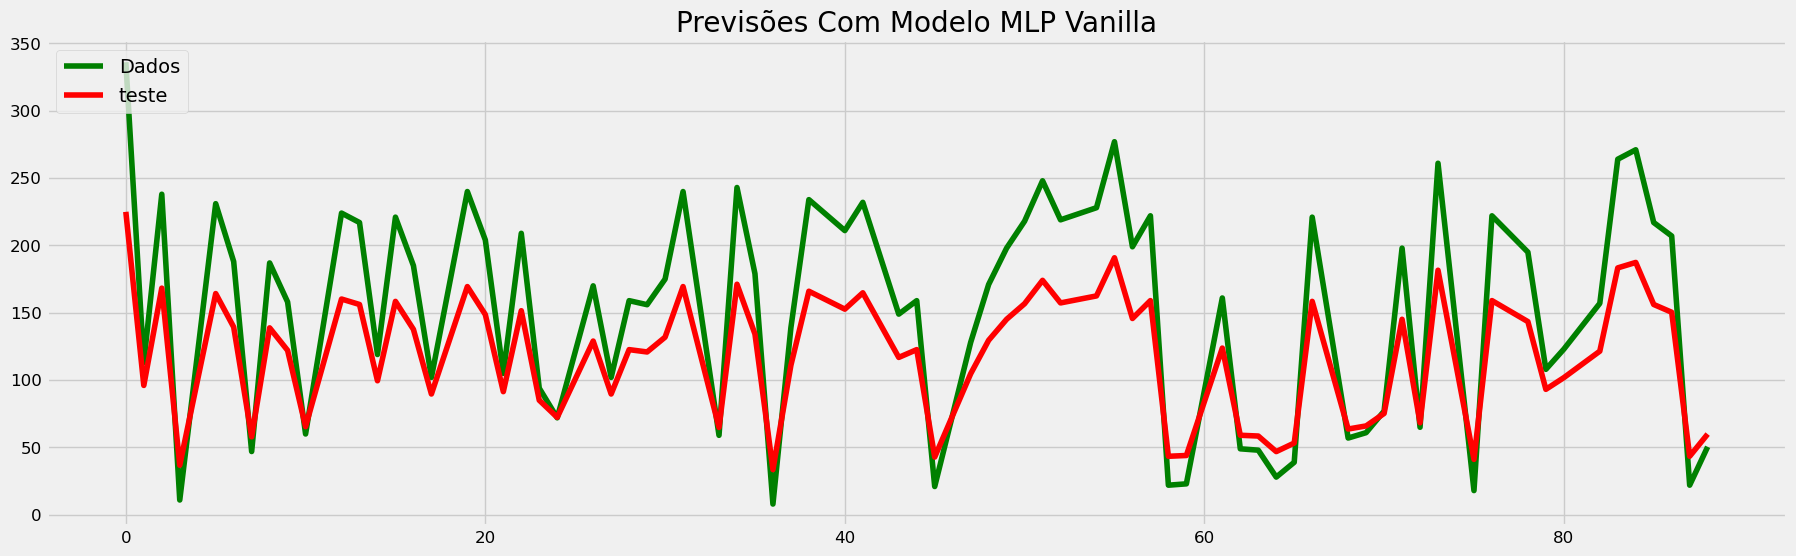

In [21]:
# Plot
plt.figure(figsize = (20, 6))
plt.title('Previsões Com Modelo MLP Vanilla')
plt.plot(dataset[-len(testPredict)-1:-2], label = 'Dados', color = 'green')
plt.plot(testPredictPlot[-len(testPredict-1):], label = 'teste', color = 'Red')
plt.legend(loc = 'upper left')
plt.show()

## Prevendo Séries Temporais com Multilayer Perceptron e Usando Método Window

Podemos também tentar resolver o problema de modo que várias etapas de tempo recente possam ser usadas para a previsão do próximo passo. Isso é chamado de método de janela (Window) e o tamanho da janela é um parâmetro que pode ser sintonizado para cada problema. Por exemplo, dado o tempo atual (t) nós queremos prever o valor na próxima vez na sequência (t + 1), podemos usar o tempo atual (T) bem como os dois tempos anteriores (t-1 e t-2). Quando formulado como um problema de regressão, as variáveis de entrada são t-2, t-1, t e a variável de saída é t + 1.

In [22]:
# Carregando os dados
dataset = dataframe.copy()
filtro1 = dataset['Broker']=='ETB170'
filtro2 = dataset['Service_name']=='PORTALDETRAN'
filtro3 = dataset['Programa']=='NSDGX500'
dataset = dataset[filtro1 & filtro2 & filtro3]

dataset.drop(columns=['Broker','Service_name','Service_class','Programa'], inplace=True)

In [23]:
# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

dataset.drop_duplicates(subset='Data', inplace=True)
dataset = dataset.set_index('Data')
dataset = dataset.resample('D').interpolate()

In [24]:
target = dataset['Quantidade']

In [25]:
raw_values = target.values

In [26]:
# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

dataset = dataset.values
dataset = dataset.astype('float32')

In [27]:
# Split em treino e teste
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

273 92


In [28]:
# Reshape em X = t e Y = t + 10
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [29]:
# Modelo MLP - Treinamento
start = time()
current_time = datetime.now().strftime("%H:%M:%S")
print("Hora de Início =", current_time)

model = Sequential()
model.add(Dense(8, input_dim = look_back, activation = 'relu'))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

current_time = datetime.now().strftime("%H:%M:%S")
print("\nHora de Término =", current_time)  
print ('Tempo gasto: %s segundos' % str(time() - start))

Hora de Início = 21:05:13
Epoch 1/200
131/131 - 1s - loss: 21415.0957 - 725ms/epoch - 6ms/step
Epoch 2/200
131/131 - 0s - loss: 6245.1084 - 455ms/epoch - 3ms/step
Epoch 3/200
131/131 - 0s - loss: 4933.4961 - 394ms/epoch - 3ms/step
Epoch 4/200
131/131 - 0s - loss: 4689.4038 - 401ms/epoch - 3ms/step
Epoch 5/200
131/131 - 0s - loss: 4530.2583 - 388ms/epoch - 3ms/step
Epoch 6/200
131/131 - 0s - loss: 4394.9688 - 394ms/epoch - 3ms/step
Epoch 7/200
131/131 - 0s - loss: 4302.1489 - 416ms/epoch - 3ms/step
Epoch 8/200
131/131 - 0s - loss: 4223.0312 - 419ms/epoch - 3ms/step
Epoch 9/200
131/131 - 0s - loss: 4134.6665 - 426ms/epoch - 3ms/step
Epoch 10/200
131/131 - 0s - loss: 4086.4236 - 443ms/epoch - 3ms/step
Epoch 11/200
131/131 - 0s - loss: 4009.4771 - 420ms/epoch - 3ms/step
Epoch 12/200
131/131 - 1s - loss: 3952.4177 - 539ms/epoch - 4ms/step
Epoch 13/200
131/131 - 0s - loss: 3905.3120 - 407ms/epoch - 3ms/step
Epoch 14/200
131/131 - 0s - loss: 3865.4143 - 392ms/epoch - 3ms/step
Epoch 15/200
131

131/131 - 0s - loss: 2981.2144 - 380ms/epoch - 3ms/step
Epoch 120/200
131/131 - 0s - loss: 2970.3188 - 411ms/epoch - 3ms/step
Epoch 121/200
131/131 - 0s - loss: 2975.5613 - 366ms/epoch - 3ms/step
Epoch 122/200
131/131 - 0s - loss: 2959.2026 - 403ms/epoch - 3ms/step
Epoch 123/200
131/131 - 0s - loss: 2972.1018 - 395ms/epoch - 3ms/step
Epoch 124/200
131/131 - 0s - loss: 2979.3047 - 381ms/epoch - 3ms/step
Epoch 125/200
131/131 - 0s - loss: 2961.7041 - 373ms/epoch - 3ms/step
Epoch 126/200
131/131 - 0s - loss: 2953.3682 - 376ms/epoch - 3ms/step
Epoch 127/200
131/131 - 0s - loss: 2974.6191 - 387ms/epoch - 3ms/step
Epoch 128/200
131/131 - 0s - loss: 2944.4827 - 375ms/epoch - 3ms/step
Epoch 129/200
131/131 - 0s - loss: 2970.1416 - 387ms/epoch - 3ms/step
Epoch 130/200
131/131 - 0s - loss: 2971.5066 - 384ms/epoch - 3ms/step
Epoch 131/200
131/131 - 0s - loss: 2955.3828 - 404ms/epoch - 3ms/step
Epoch 132/200
131/131 - 0s - loss: 2947.9531 - 416ms/epoch - 3ms/step
Epoch 133/200
131/131 - 0s - loss:

In [30]:
# Modelo MLP - Treinamento
start = time()
current_time = datetime.now().strftime("%H:%M:%S")
print("Hora de Início =", current_time)

model = Sequential()
model.add(Dense(8, input_dim = look_back, activation = 'relu'))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

current_time = datetime.now().strftime("%H:%M:%S")
print("\nHora de Término =", current_time)  
print ('Tempo gasto: %s segundos' % str(time() - start))

Hora de Início = 22:40:06
Epoch 1/200
131/131 - 1s - loss: 8974.5342 - 722ms/epoch - 6ms/step
Epoch 2/200
131/131 - 0s - loss: 4897.8418 - 427ms/epoch - 3ms/step
Epoch 3/200
131/131 - 0s - loss: 4634.8828 - 417ms/epoch - 3ms/step
Epoch 4/200
131/131 - 0s - loss: 4423.0654 - 422ms/epoch - 3ms/step
Epoch 5/200
131/131 - 0s - loss: 4264.8545 - 421ms/epoch - 3ms/step
Epoch 6/200
131/131 - 0s - loss: 4114.3701 - 407ms/epoch - 3ms/step
Epoch 7/200
131/131 - 0s - loss: 4048.6704 - 399ms/epoch - 3ms/step
Epoch 8/200
131/131 - 0s - loss: 3969.2375 - 479ms/epoch - 4ms/step
Epoch 9/200
131/131 - 0s - loss: 3923.4353 - 403ms/epoch - 3ms/step
Epoch 10/200
131/131 - 0s - loss: 3838.2192 - 390ms/epoch - 3ms/step
Epoch 11/200
131/131 - 0s - loss: 3801.7268 - 403ms/epoch - 3ms/step
Epoch 12/200
131/131 - 0s - loss: 3753.2549 - 397ms/epoch - 3ms/step
Epoch 13/200
131/131 - 0s - loss: 3739.8540 - 399ms/epoch - 3ms/step
Epoch 14/200
131/131 - 0s - loss: 3703.6477 - 411ms/epoch - 3ms/step
Epoch 15/200
131/

Epoch 120/200
131/131 - 0s - loss: 2984.7937 - 390ms/epoch - 3ms/step
Epoch 121/200
131/131 - 0s - loss: 2960.7595 - 390ms/epoch - 3ms/step
Epoch 122/200
131/131 - 0s - loss: 2947.7065 - 379ms/epoch - 3ms/step
Epoch 123/200
131/131 - 0s - loss: 2975.6667 - 402ms/epoch - 3ms/step
Epoch 124/200
131/131 - 0s - loss: 2990.8875 - 379ms/epoch - 3ms/step
Epoch 125/200
131/131 - 0s - loss: 2966.6472 - 387ms/epoch - 3ms/step
Epoch 126/200
131/131 - 0s - loss: 2913.7502 - 394ms/epoch - 3ms/step
Epoch 127/200
131/131 - 0s - loss: 2950.0027 - 377ms/epoch - 3ms/step
Epoch 128/200
131/131 - 0s - loss: 2968.4265 - 395ms/epoch - 3ms/step
Epoch 129/200
131/131 - 0s - loss: 2949.1274 - 431ms/epoch - 3ms/step
Epoch 130/200
131/131 - 0s - loss: 2896.1646 - 406ms/epoch - 3ms/step
Epoch 131/200
131/131 - 0s - loss: 2919.1714 - 438ms/epoch - 3ms/step
Epoch 132/200
131/131 - 0s - loss: 2939.6255 - 421ms/epoch - 3ms/step
Epoch 133/200
131/131 - 0s - loss: 2916.7598 - 404ms/epoch - 3ms/step
Epoch 134/200
131/13

In [30]:
# Performance do Modelo
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Score em Treino: %.4f MSE (%.4f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Score em Teste: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

Score em Treino: 2841.4524 MSE (53.3053 RMSE)
Score em Teste: 5259.2476 MSE (72.5207 RMSE)


In [31]:
# Previsões para treino e teste
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

3/3 [==============================] - 0s 3ms/step


In [32]:
# Ajustando as previsões de treino para o Plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajustando as previsões de teste para o Plot
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

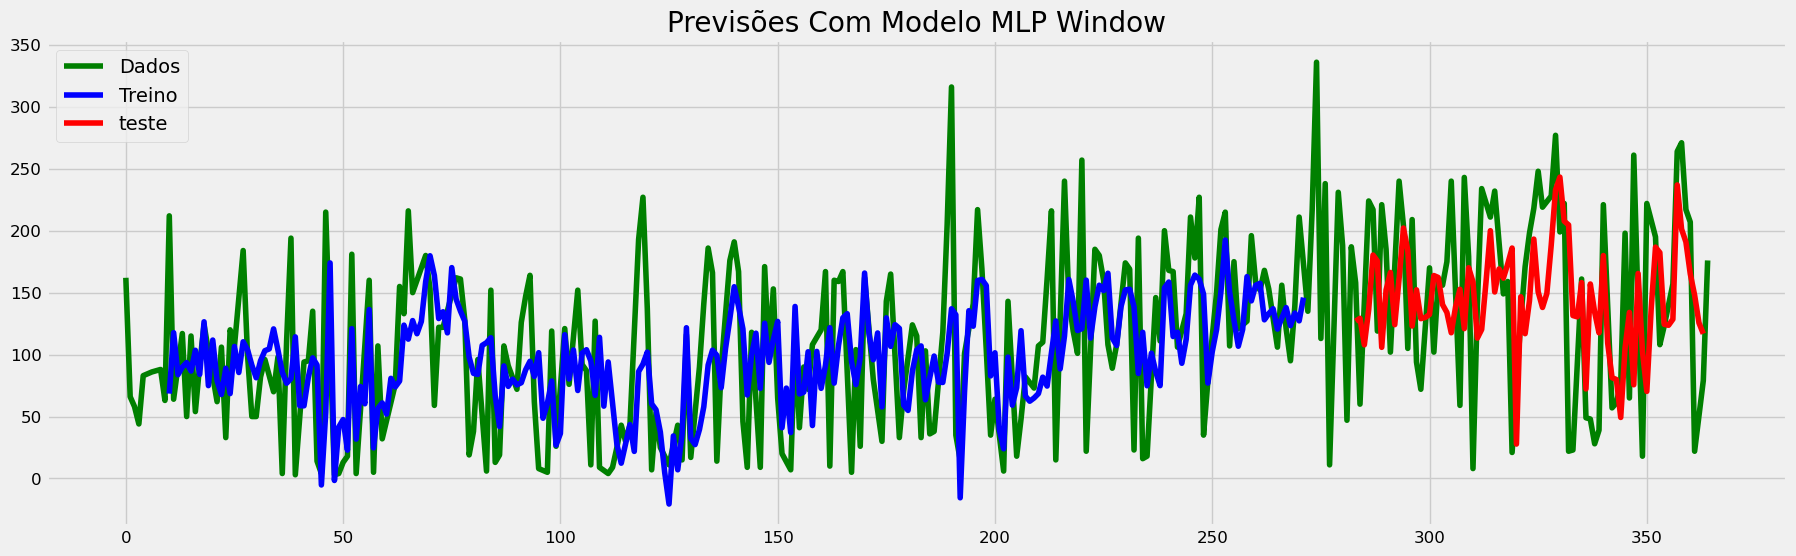

In [33]:
# Plot do baseline e previsões
# Podemos ver que o erro foi reduzido em comparação com o da seção anterior. 
# O tamanho da janela e a arquitetura da rede não foram sintonizados, isso é apenas uma demonstração de como
# enquadrar um problema de previsão em séries temporais. 
# Plot
plt.figure(figsize = (20, 6))
plt.title('Previsões Com Modelo MLP Window')
plt.plot(dataset, label = 'Dados', color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(testPredictPlot, label = 'teste', color = 'Red')
plt.legend(loc = 'upper left')
plt.show()

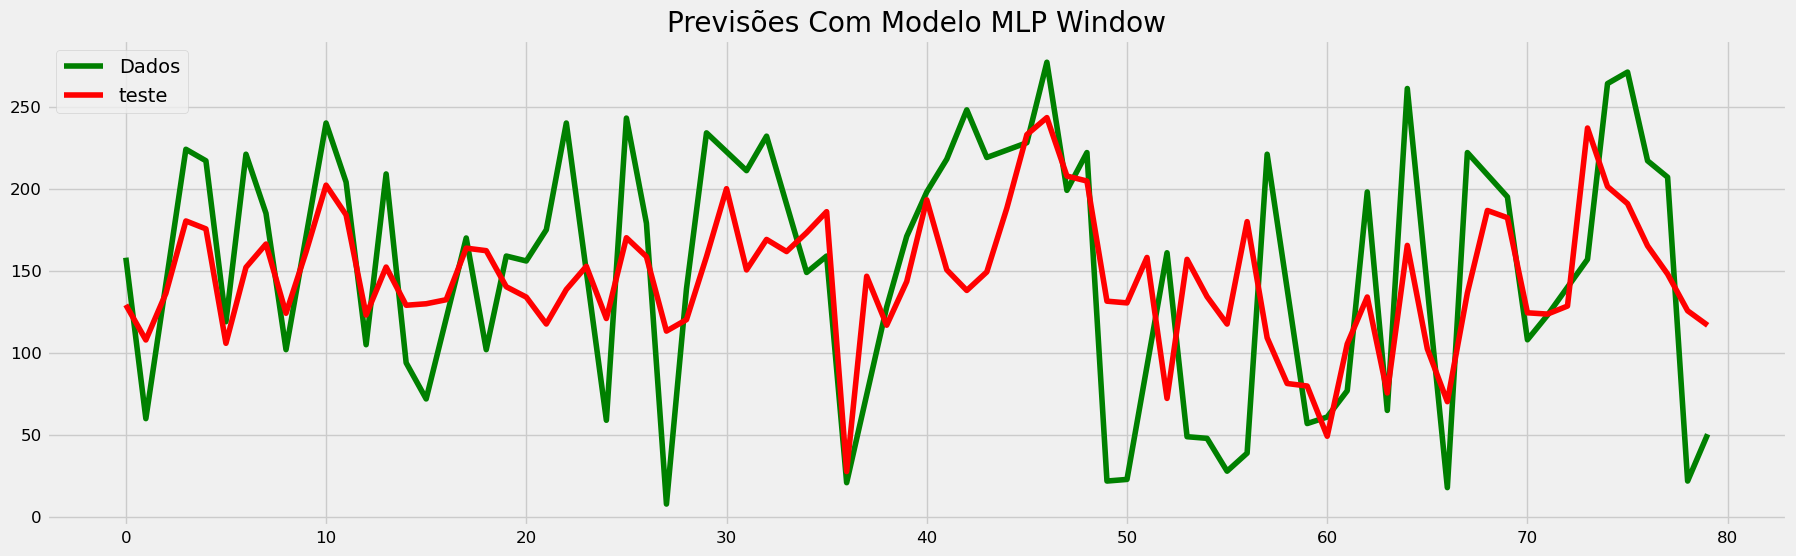

In [34]:
# Plot
plt.figure(figsize = (20, 6))
plt.title('Previsões Com Modelo MLP Window')
plt.plot(test[-len(testPredict)-1:-2], label = 'Dados', color = 'green')
plt.plot(testPredictPlot[-len(testPredict-1):], label = 'teste', color = 'Red')
plt.legend(loc = 'upper left')
plt.show()

## Vamos fazer o Forecasting para 82 dias de horizonte de previsão

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Fazemos uma previsão em uma etapa
def forecast_lstm(model, X):
    X = X.reshape(1, look_back)
    yhat = model.predict(X)
#    yhat1 = scaler.inverse_transform(yhat)
    return yhat[0,0]

In [37]:
# Validação direta nos dados de teste

# Lista para as previsões
previsoes_lstm = list()

# Previsões

for i in range(len(testX)):   
   
    # Ajusta o shape dos dados de teste
    X, y = testX[i], testY[i]
    
    # Previsão

    yhat = forecast_lstm(model, X)
    
    # Armazena o forecast
    previsoes_lstm.append(yhat)
    expected = raw_values[len(testX) + i ]
    
    print('Mês = %d, Valor Previsto = %f, Valor Esperado = %f' % (i + 1, yhat, expected))

1/1 [==============================] - 0s 26ms/step
Mês = 1, Valor Previsto = 126.977379, Valor Esperado = 96.000000
1/1 [==============================] - 0s 26ms/step
Mês = 2, Valor Previsto = 129.275970, Valor Esperado = 51.000000
1/1 [==============================] - 0s 25ms/step
Mês = 3, Valor Previsto = 107.887810, Valor Esperado = 6.000000
1/1 [==============================] - 0s 25ms/step
Mês = 4, Valor Previsto = 136.253876, Valor Esperado = 152.000000
1/1 [==============================] - 0s 26ms/step
Mês = 5, Valor Previsto = 180.361191, Valor Esperado = 13.000000
1/1 [==============================] - 0s 25ms/step
Mês = 6, Valor Previsto = 175.537277, Valor Esperado = 19.000000
1/1 [==============================] - 0s 25ms/step
Mês = 7, Valor Previsto = 105.870674, Valor Esperado = 107.000000
1/1 [==============================] - 0s 26ms/step
Mês = 8, Valor Previsto = 152.103729, Valor Esperado = 91.000000
1/1 [==============================] - 0s 28ms/step
Mês = 9, Va

1/1 [==============================] - 0s 25ms/step
Mês = 71, Valor Previsto = 182.334244, Valor Esperado = 20.000000
1/1 [==============================] - 0s 26ms/step
Mês = 72, Valor Previsto = 124.444702, Valor Esperado = 13.500000
1/1 [==============================] - 0s 25ms/step
Mês = 73, Valor Previsto = 123.657326, Valor Esperado = 7.000000
1/1 [==============================] - 0s 26ms/step
Mês = 74, Valor Previsto = 128.548431, Valor Esperado = 114.000000
1/1 [==============================] - 0s 26ms/step
Mês = 75, Valor Previsto = 236.944046, Valor Esperado = 41.000000
1/1 [==============================] - 0s 25ms/step
Mês = 76, Valor Previsto = 201.272949, Valor Esperado = 90.000000
1/1 [==============================] - 0s 25ms/step
Mês = 77, Valor Previsto = 190.897125, Valor Esperado = 72.000000
1/1 [==============================] - 0s 25ms/step
Mês = 78, Valor Previsto = 165.194427, Valor Esperado = 108.000000
1/1 [==============================] - 0s 25ms/step
Mês

In [38]:
# Última data da série
target.index[-1]

Timestamp('2022-10-25 00:00:00', freq='D')

In [39]:
# Cria sequência de datas a partir da última data da nossa série original

datas_para_prever_forecasting = [target.index[-1] + DateOffset(days = x) for x in range(0, 82)]

In [40]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [41]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [42]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
data_futuras

,Quantidade
2022-10-26,NaN
2022-10-27,NaN
2022-10-28,NaN
2022-10-29,NaN
2022-10-30,NaN
...,...
2023-01-10,NaN
2023-01-11,NaN
2023-01-12,NaN
2023-01-13,NaN


In [43]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(testPredict,
                          index = data_futuras.index, columns = ['Prediction'])

In [44]:
# Concatenamos a série original com os valores de forecasting de 134 dias além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [45]:
# Visualiza o dataframe
df_forecasting

,Quantidade,Prediction
2021-10-26,162.0,NaN
2021-10-27,66.0,NaN
2021-10-28,58.0,NaN
2021-10-29,44.0,NaN
2021-10-30,83.0,NaN
...,...,...
2023-01-10,NaN,190.897110
2023-01-11,NaN,165.194412
2023-01-12,NaN,148.023148
2023-01-13,NaN,125.679253


In [46]:
# Visualiza o dataframe
df_forecasting

,Quantidade,Prediction
2021-10-26,162.0,NaN
2021-10-27,66.0,NaN
2021-10-28,58.0,NaN
2021-10-29,44.0,NaN
2021-10-30,83.0,NaN
...,...,...
2023-01-10,NaN,190.897110
2023-01-11,NaN,165.194412
2023-01-12,NaN,148.023148
2023-01-13,NaN,125.679253


In [47]:
df_forecasting.to_csv(r'./CSV/PipaMainframe_Forecasting_MLP_Window.csv', index = False)

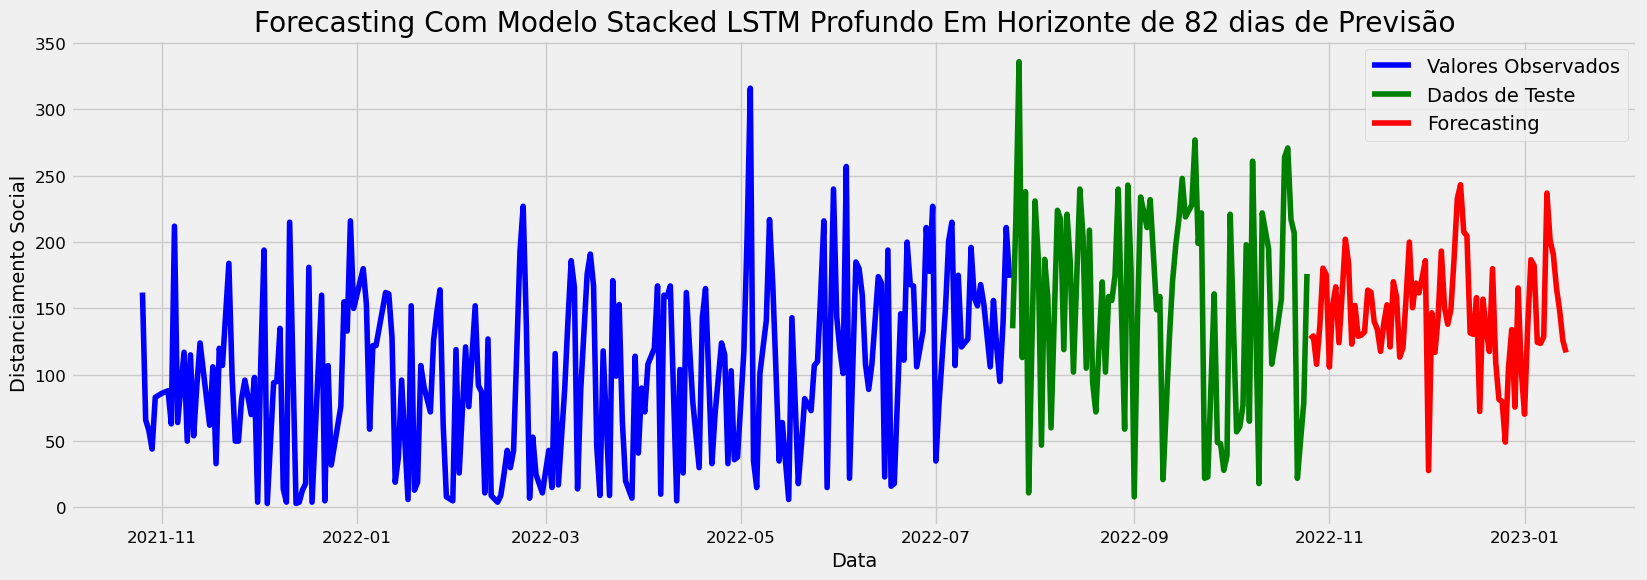

In [48]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(target.index[0:272], target.values[0:272], label = 'Valores Observados', color = 'Blue')
plt.plot(target.index[272:], target.values[272:], label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo Stacked LSTM Profundo Em Horizonte de 82 dias de Previsão')
plt.xlabel('Data')
plt.ylabel('Distanciamento Social')
plt.legend()
plt.show()

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

# Fim